# Computer Vision Lab Project - JKU - 2021
### Team B0
  
Team Members: Dominik Heindl, Philipp Eberstaller, Carson Wittwer  

In [74]:
from abc import ABC, abstractmethod
import glob
import json
import os
import sys
import copy
from skimage.metrics import structural_similarity
from time import time, gmtime, strftime
from typing import Tuple, Dict, List
from evaluate import evaluate

import cv2
import matplotlib.pyplot as plt
import numpy as np
import spectral as sp
from scipy.stats import chi2

import torch
from torchvision.io import write_video
from torchvision.transforms import functional, ToTensor, Lambda, Compose
from torchvision.utils import save_image

import utils as ut

from clahe import clahe

#### Loading Data Utilities

In [3]:
def load_homographies(input_dir: str):
    """
    Finds all homographies.json files recursively in a given input directory.

    Args:
        input_dir: Input directory which contains .json files

    Returns:
        A dictionary mapping the folder names to dictionaries with the homographies
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Name (e.g. 0-B01): List[homographies]}}}
    """
    sorted_homographies = sorted(glob.glob(
        os.path.join(input_dir, '**', '*ies.json'),
        recursive=True
    ))

    homographies = {}

    for file in sorted_homographies:
        folders, file_name = os.path.split(file)
        folder_name = os.path.basename(folders)

        homographies[folder_name] = json.loads(open(file, 'r').read())

    return homographies

def load_numpy_array(file_path: str) -> np.ndarray:
    """Loads a saved and compressed numpy array"""
    arr = np.load(file_path)
    return arr['arr_0']

def read_images(
        input_dir: str,
        mask: np.ndarray,
        integrated_only: bool = True
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        integrated_only: Whether to load only the integrated

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    if integrated_only:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*-int_image.png'),
            recursive=True
        ))
    else:
        sorted_files = sorted(glob.glob(
            os.path.join(input_dir, '**', '*.png'),
            recursive=True
        ))

        homographies = load_homographies(input_dir)

    original_images = {}
    warped_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)

        #if not integrated_only:
        #    if any(x not in file_name for x in ('mask', 'int_image', 'mask_image')):
        #        print('here')
        #        continue

        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images and folder_name not in warped_images:
                original_images[folder_name] = {}
                warped_images[folder_name] = {}

        if file_set not in original_images[folder_name] and file_set not in warped_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            warped_images[folder_name].update({file_set: {}})

        img = cv2.imread(file)

        if not integrated_only:
            if folder_name not in warped_images:
                warped_images[folder_name] = {}

            if file_set not  in warped_images[folder_name]:
                warped_images[folder_name].update({file_set: {}})

            w, h, _ = img.shape
            img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp

            homography = np.array(homographies[folder_name][file_name]) #get homography

            warped_img = cv2.warpPerspective(img, homography, (w,h)) #warp the image using the given homography
            warped_images[folder_name][file_set].update({file_name: warped_img})

        original_images[folder_name][file_set].update({file_name: img}) #save the original

    return original_images, warped_images


#### Other Utilities


In [4]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()

def integrate(images: list):

    """
    Takes a list of images and integrates them and returns the integrated image 
    and overlap mask where all 7 images overlap
    """
    integral = np.zeros((images[0].shape), np.float64)
    mask = np.zeros((images[0].shape), np.float64)
    mask = mask[:,:,0]
    mask_ = np.copy(mask)

    for j in range(len(images)):
        integral += images[j]
        
        a,b = np.where(np.all(images[j]==[0,0,0],axis=2))
        pix_locs = np.column_stack((a,b))
        for c,d in pix_locs:
            mask[c,d] += 1
    
    x,y = mask.shape
    for n in range(x):
        for m in range(y):
            if mask[n,m] == 0: #0 means this pixel has all 10 images merged
                mask_[n,m] = 1
            else:
                mask_[n,m] = 0
    
    #cv2.cvtColor(np.float32(mask_),cv2.COLOR_GRAY2BGR)

    #mask_images.append(mask_)
    integral /= len(images)
    integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    #integrated_images.append(integral)

    return integral, mask_

def color_check(image: np.ndarray):
    height, width = image.shape[:2]
    cc = np.zeros(image.shape, np.float64)
    for y,x in zip(range(height),range(width)):
        if all(image[x,y] != [0,0,0]):
            cc[x,y]=[0,0,0]
    return np.array(cc)

def crop_image(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_OTSU)

    bbox = cv2.boundingRect(thresh)
    x,y,w,h = bbox
    
    return x,y,w,h

In [5]:
def get_background_median(images):
    return np.median(images,axis=0).astype(np.uint8)

def get_background_mean(images):
    return np.mean(images,axis=0).astype(np.uint8)

def fixColor(image):
    return(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR))

def preprocess(images: list):
    tensorizer = ToTensor()

    brightness_factor = 0.3
    contrast_factor = 4
    bri_cont_transform = Compose([
        Lambda(lambda x: functional.adjust_brightness(x, brightness_factor)),
        Lambda(lambda x: functional.adjust_contrast(x, contrast_factor))])

    # bri_cont_transform = ColorJitter(brightness=0.4, contrast=3)
    inverter_transform = Lambda(lambda x: functional.invert(x))

    ims = images.copy()

    inv = []

    for i in range(len(ims)):
        ims[i] = tensorizer(ims[i])
        bri_cont = bri_cont_transform(ims[i])
        inverted = inverter_transform(bri_cont)
        temp=inverted.permute(1, 2, 0).numpy()
        inv.append(temp)
        #inv.append(cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY))

    return inv

## Anomaly Detection

I think it is good if we use a proper base class for the anomaly detection, this should ensure a unified interface which can be used at any point in our pipeline. Basically any algorithm implementation / class should have the method `anomaly_mask` which should return a mask where outliers are marked with 1 and other pixels remain 0.

In [6]:
class AnomalyDetection(ABC):
    def __init__(self, img: np.ndarray):
        self.img = img

    @abstractmethod
    def anomaly_mask(self) -> np.ndarray:
        """
        Takes whatever is necessary from the current object to generate an anomaly
        mask. The mask has the same height and width as the input image, anomalies are
        marked as 1, everything als with 0.
        """
        pass

### Residual Approach

Originally this should be an implementation from `Reducing Anomaly Detection in Images to Detection in Noise` by Davy et al. The implementation is heavily influenced from this [GitHub Repository](https://github.com/whynotw/reducing_anomaly_detection), however by pure chance I stumbled across the fact that a burred version of the residual image is already looking promising for detection outliers. <br>
A disadvantage is that this algorithm takes ~1 min. per image to create the anomaly mask!

In [7]:
class ResidualAnomaly(AnomalyDetection):
    def __init__(
            self,
            img: np.ndarray,
            filter_size: int = 7,
            stride: int = 3,
            number_k: int = 5,
            threshold_intensity: int = 9
    ):
        super().__init__(img)
        if filter_size % 2 == 0:
            print("size of filter %d should be odd number" % filter_size)
        self.filter_size = filter_size
        self.stride = stride
        self.k = number_k
        self.threshold_intensity = threshold_intensity

        self.image_origin = img
        h, w, _ = img.shape

        h_remain = (h - filter_size) % stride
        w_remain = (w - filter_size) % stride
        self.image_origin = self.image_origin[:h - h_remain, :w - w_remain, :]

        self.h, self.w, _ = self.image_origin.shape
        self.h_red = (self.h - self.filter_size) // self.stride + 1
        self.w_red  = (self.w - self.filter_size) // self.stride + 1
        self.dim_data = 3 * self.filter_size ** 2
        self.img_acc = np.zeros((self.h, self.w, 3), dtype=np.float32)
        self.pixel_count = np.zeros((self.h, self.w), dtype=np.uint8)

        tmp_idx = np.arange(0, self.w_red * self.stride, self.stride, dtype=np.uint16)
        self.x0_data = np.stack((tmp_idx, ) * self.h_red)
        self.x1_data = self.x0_data+self.filter_size

        tmp_idx = np.arange(0, self.h_red * self.stride, self.stride, dtype=np.uint16)
        self.y0_data = np.stack((tmp_idx, ) * self.w_red).T
        self.y1_data = self.y0_data+self.filter_size
        self.knn = cv2.ml.KNearest_create()

        self.mask = None

    def _create_patches(self):
        """
        Divides the given image into pathes with size filter_size x filter_size.
        The filter is then moves forward for stride pixels. All patches are saved
        in the data object for the knn algorithm.

        Returns:
            None
        """
        self.data_total  = np.empty((self.h_red, self.w_red, self.dim_data), dtype=np.uint8)
        self.label_total = np.empty((self.h_red, self.w_red, 1), dtype=np.float32)

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                x0 = i * self.stride
                x1 = x0 + self.filter_size
                y0 = j * self.stride
                y1 = y0 + self.filter_size
                self.data_total[j, i, :] = self.image_origin[y0:y1, x0:x1, :].reshape(-1)
                self.label_total[j, i, 0] = count
                count += 1

    def _get_knn(self):
        """
        Performs a knn algorithm on the previously calculated patches. This should
        ensure that anomalies are true anomalies and not part of some bigger pattern

        Returns:
            None
        """
        tmp_data = self.data_total.reshape((-1, self.dim_data)).astype(np.float32)

        self.knn.train(
            tmp_data,
            cv2.ml.ROW_SAMPLE,
            self.label_total.reshape(-1,1)
        )

        _, _, neighbours, distances = self.knn.findNearest(
            tmp_data,
            self.filter_size ** 2 + self.k
        )
        neighbours = neighbours.astype(np.int64)

        return neighbours, distances

    def _get_self_similar_estimate(self):
        """
        Creates a "self-similar" version of each image patch which is later used
        to create the residual image. The average values of the neighbour patches
        are divided from the current patch.

        Returns:
            None
        """
        neighbours,distances = self._get_knn()

        count = 0
        for j in range(0, self.h_red):
            for i in range(0, self.w_red):
                patch = np.zeros((self.filter_size, self.filter_size, 3), dtype=np.float32)
                x0 = self.stride * i
                x1 = x0 + self.filter_size
                y0 = self.stride * j
                y1 = y0 + self.filter_size

                partition = 1e-7
                effective = -1

                for k in range(len(neighbours)):
                    n = neighbours[count][k]
                    j_neighbour = n // self.w_red
                    i_neighbour = n % self.w_red

                    d = distances[count][k]

                    x0_n = self.stride * i_neighbour
                    x1_n = x0_n + self.filter_size
                    y0_n = self.stride * j_neighbour
                    y1_n = y0_n + self.filter_size

                    if x0 > x1_n or x1 < x0_n or y0 > y1_n or y1 < y0_n:
                        effective += 1
                    else:
                        continue

                    if effective == 0:
                        d0 = d

                    if effective >= self.k:
                        break

                    d -= d0
                    factor = np.exp(-d/self.dim_data)

                    if factor > 2**-8:
                        patch += factor * (
                            self.data_total[j_neighbour,i_neighbour,:]
                                .reshape((self.filter_size, self.filter_size, 3))
                        )
                        partition += factor

                self.img_acc[y0:y1, x0:x1, :] += patch / partition
                self.pixel_count[y0:y1, x0:x1] += 1
                count += 1

        self.img_red = np.uint8(self.img_acc / np.stack((self.pixel_count,) * 3, axis=-1))

    def anomaly_mask(self):
        """
        Calculates the residual image -> original image - self similar version of it.
        Then apply a GaussianBlus which removes weak outlier signals. The blurred image
        is then filtered for the top outlier value > some threshold.

        Returns:
            Anomaly mask where anomalies are 0, everything else is 0
        """
        self._create_patches()
        self._get_self_similar_estimate()
        tmp_residual = np.uint8(
            np.sum(
                np.abs(
                    np.int16(self.img_red) - np.int16(self.image_origin)
                ),
                axis=-1
            ) / 3
        )

        tmp_blurred = cv2.GaussianBlur(
            tmp_residual,
            (self.filter_size * 2 + 1,) * 2,
            0
        )

        # mask = np.where(tmp_blurred >= self.threshold_intensity, 1, 0)
        # self.mask = mask

        return tmp_blurred

In [110]:
def calculate_anomaly_mask(
        img: np.ndarray,
        overlapping_mask: np.ndarray,
        filter_size: int,
        stride: int,
        number_k: int
):
    """
    Calculate the anomaly masks with the Residual approach in a more efficient way
    by cropping only the center part where all cameras are overlapping. This info
    is provided by the overlapping mask which has to be computed beforehand.

    Args:
        img: Integrated image of which the anomaly mask should be computed
        overlapping_mask: 2D-array which indicates the area of the img which is part of all 10 camera views
        filter_size: Size of the filter used to create patches in the Residual anomaly detection
        stride: Number of pixels the filter should move forward
        number_k: Number of neighbours which should be used for the knn algorithm

    Returns:
        An anomaly mask with the size of the original image,
        only showing anomalies where all camera views overlap
    """
    # get the coordinates of the mask for overlapping images
    non_zero_x, non_zero_y = np.nonzero(overlapping_mask)
    idx = [non_zero_x.min(), non_zero_x.max(), non_zero_y.min(), non_zero_y.max()]

    # copy og image and select only the relevant center
    img_cp = img.copy()
    img_cp = img_cp[idx[0]: idx[1], idx[2]: idx[3], :]

    # start anomaly detection with the cropped image
    reducing = ResidualAnomaly(
        img=img_cp,
        filter_size=filter_size,
        stride=stride,
        number_k=number_k
    )
    red_mask = reducing.anomaly_mask()

    # pad the resulting anomaly mask to fit the cropped image if necessary
    h_img, w_img, _ = img_cp.shape
    h_mask, w_mask = red_mask.shape
    if not h_img == h_mask or not w_img == w_mask:
        h_pad = (h_img - h_mask)
        w_pad = (w_img - w_mask)
        red_mask = np.pad(
            red_mask,
            pad_width=((h_pad // 2, h_pad // 2 + h_pad % 2), (w_pad // 2, w_pad // 2 + w_pad % 2)),
            mode='constant'
        )

    # create anomaly mask with original image dimensions and add the calculated region
    red_mask_ = np.zeros((img.shape[0], img.shape[1]))
    red_mask_[idx[0]: idx[1], idx[2]: idx[3]] = red_mask

    return  red_mask_

## Bounding Boxes

### Add given BB

In [9]:
def add_bounding_boxes(
        img: np.ndarray,
        gtlabels: List[List[int]],
        rgb_color: Tuple[int] = (0, 0, 255),
        thickness: int = 5
) -> np.ndarray:
    """
    Adds the given bounding boxes to an image. These bounding boxes are
    only aligned for the center image!

    Args:
        img: Image to which bounding boxes should be added
        gtlabels: Bounding boxes from a labels.json file
        rgb_color: Tuple representing the RGB color of the box
        thickness: Thickness of the box line

    Returns:
        Image with an overlayed bounding boxes
    """
    img_processed = img.copy()
    for bb in gtlabels:
        x, y, w, h = bb
        img_processed = cv2.rectangle(
            img=img_processed,
            pt1=(x,y),
            pt2=(x+w, y+h),
            color=rgb_color,
            thickness=thickness
        )

    return img_processed

### Create new BB from anomaly mask

In [10]:
def is_close(cnt1,cnt2, max_dist=30):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < max_dist:
                return True
            elif i==row1-1 and j==row2-1:
                return False

def combine_contours(contours):
    n = len(contours)
    status = np.zeros((n,1))
    
    for i,cnt1 in enumerate(contours):
        x = i    
        if i != n-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = is_close(cnt1,cnt2)
                if dist:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)
                
    return unified

def area_filled(contour,mask):
    
    contour_area=np.zeros_like(mask)
    cv2.drawContours(contour_area, [contour], -1, 1, -1)
    mask_area=contour_area[mask.astype(bool)].sum()

    return mask_area.sum()

### Create new BB from anomaly mask

In [11]:
def get_bounding_boxes(mask, min_area=125):
    
    contours = cv2.findContours(mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    
    if not len(contours):
        detected_anomalies_bb = np.zeros((0,4))
        
        return detected_anomalies_bb, contours

    combined = contours   
    #combined = combine_contours(contours)
    combined = [c for c in combined if not area_filled(c,mask)<min_area]
    
    if not len(combined):
        detected_anomalies_bb = np.zeros((0,4))
        return detected_anomalies_bb, combined
    
    detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in combined])
    
    return detected_anomalies_bb, combined

## Evaluate Process

### Bring in all the data

In [12]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/'

mask = cv2.imread(MASK,0)

orig_images, warped_images = read_images(IMAGE_FOLDER, mask, integrated_only=False)

integrated_images = copy.deepcopy(warped_images)
overlap_masks = copy.deepcopy(warped_images)


##### Quick all good check

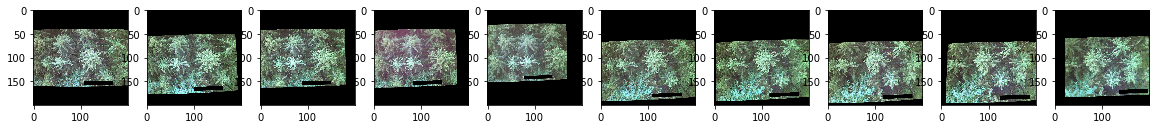

In [13]:
temp = []
for cam, img in warped_images['valid-1-0']['0'].items():
    temp.append(img)

display_images(temp,figsize=(1,10))

### Integrate the images, identify the overlap masks

In [14]:
for img_set, time_step_dict in warped_images.items():
        for time_step, n_camera_dict in time_step_dict.items():
            images = []
            for cam, img in n_camera_dict.items():
                images.append(img)
            print("Working on: ",img_set,",",time_step)
            start = time()
            integrated_image, overlap_mask = integrate(images)   
            integrated_images[img_set][time_step] = integrated_image
            overlap_masks[img_set][time_step] = overlap_mask
            print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))}")

Working on:  valid-1-0 , 0
It took 00:00:08
Working on:  valid-1-0 , 1
It took 00:00:08
Working on:  valid-1-0 , 2
It took 00:00:08
Working on:  valid-1-0 , 3
It took 00:00:08
Working on:  valid-1-0 , 4
It took 00:00:08
Working on:  valid-1-0 , 5
It took 00:00:08
Working on:  valid-1-0 , 6
It took 00:00:08
Working on:  valid-1-1 , 0
It took 00:00:08
Working on:  valid-1-1 , 1
It took 00:00:08
Working on:  valid-1-1 , 2
It took 00:00:08
Working on:  valid-1-1 , 3
It took 00:00:08
Working on:  valid-1-1 , 4
It took 00:00:08
Working on:  valid-1-1 , 5
It took 00:00:08
Working on:  valid-1-1 , 6
It took 00:00:08
Working on:  valid-1-2 , 0
It took 00:00:08
Working on:  valid-1-2 , 1
It took 00:00:08
Working on:  valid-1-2 , 2
It took 00:00:08
Working on:  valid-1-2 , 3
It took 00:00:08
Working on:  valid-1-2 , 4
It took 00:00:08
Working on:  valid-1-2 , 5
It took 00:00:08
Working on:  valid-1-2 , 6
It took 00:00:08
Working on:  valid-1-3 , 0
It took 00:00:08
Working on:  valid-1-3 , 1
It to

##### Quick image integration and overlap mask check

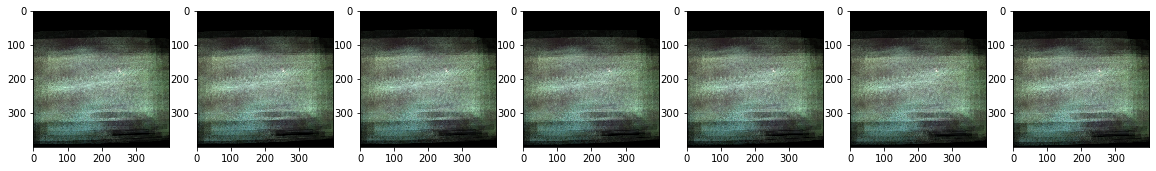

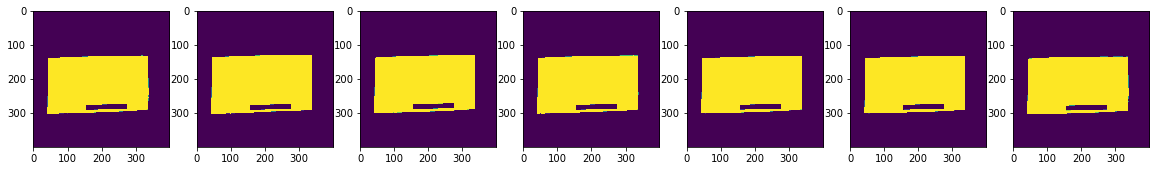

In [58]:
temp2 = []
for time_step, img in integrated_images['valid-1-0'].items():
    temp2.append(img)

temp3 = []
for time_step, img in overlap_masks['valid-1-0'].items():
    temp3.append(img)

display_images(temp2,figsize=(1,7), resize_dim=(400,400))
display_images(temp3,figsize=(1,7), resize_dim=(400,400))

### Anomaly Detection and anomaly mask creation

It took 00:00:08
It took 00:00:09
It took 00:00:08
It took 00:00:08
It took 00:00:07
It took 00:00:08
It took 00:00:08


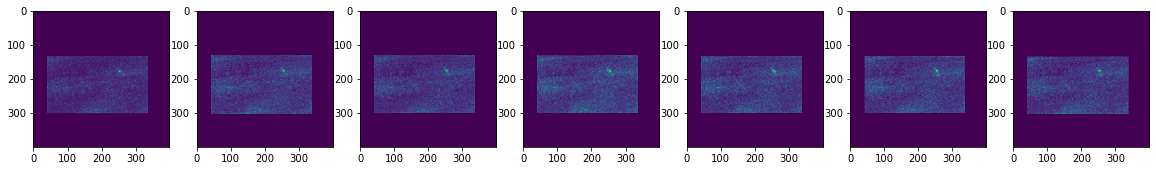

In [111]:
#quick check to make sure anomaly detection works
temp4 = []
for time_step, img in integrated_images['valid-1-0'].items():
    start = time()

    red_mask_ = calculate_anomaly_mask(
                img=img,
                overlapping_mask=overlap_masks['valid-1-0'][time_step],
                filter_size=5,
                stride=3,
                number_k=5
            )

    temp4.append(red_mask_)
    print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))}")

display_images(temp4,figsize=(1,7), resize_dim=(400,400))


In [62]:
anomaly_masks = copy.deepcopy(integrated_images)

"""calculate anomaly masks"""
for folder, time_step_dict in integrated_images.items():
    for time_step, img in time_step_dict.items():

        start = time()

        # TODO: check the parameters here, could also use filter_size=3 and stride=2
        red_mask_ = calculate_anomaly_mask(
                    img=img,
                    overlapping_mask=overlap_masks[folder][time_step],
                    filter_size=5,
                    stride=3,
                    number_k=5
                )

        anomaly_masks[folder][time_step] = red_mask_
        print(f"It took {strftime('%H:%M:%S', gmtime(time()-start))} to create the Anomaly Mask")



It took 00:00:08 to create the Anomaly Mask
It took 00:00:09 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the Anomaly Mask
It took 00:00:08 to create the A

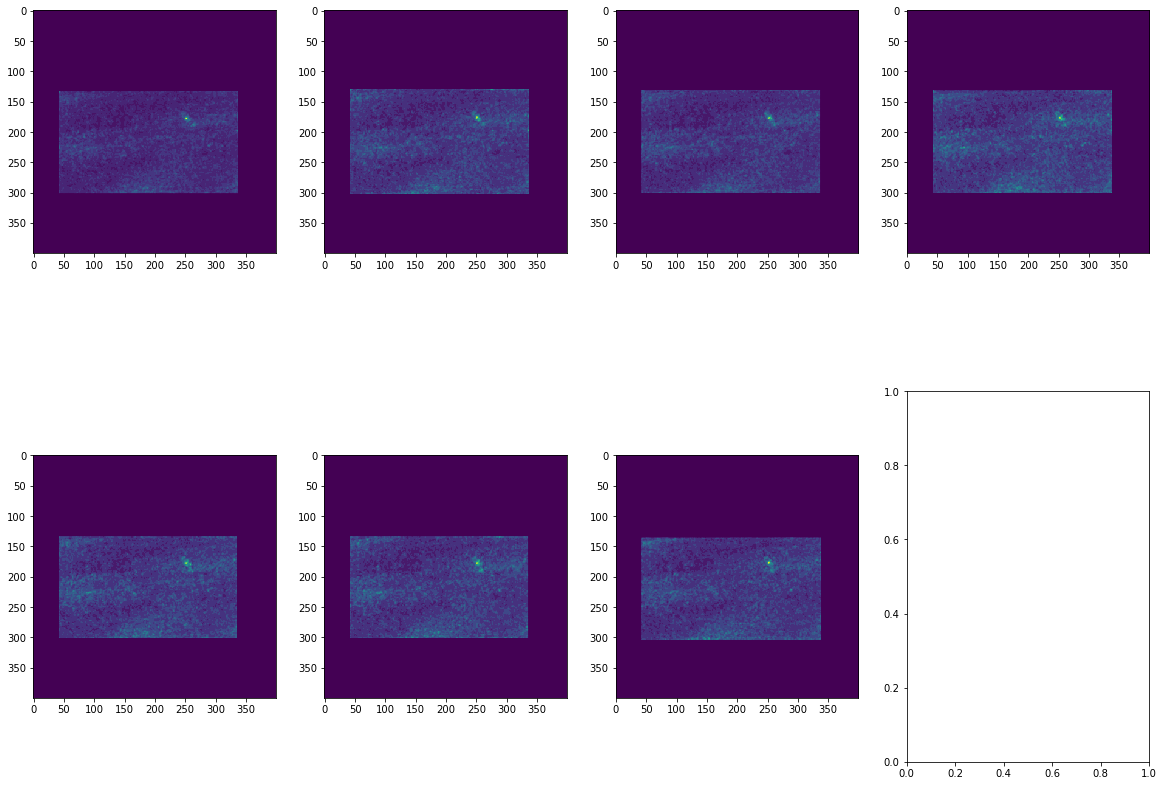

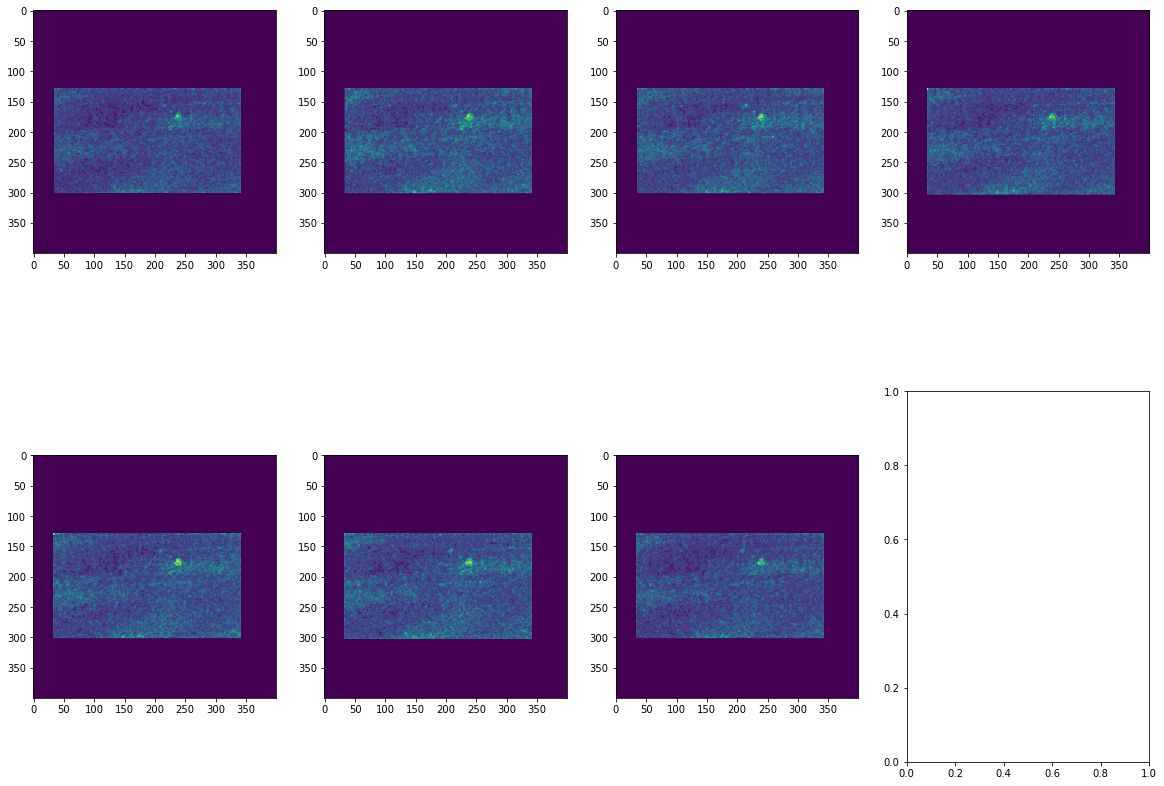

In [63]:
#Check to make sure full anomaly detection worked

temp5 = []
for time_step, img in anomaly_masks['valid-1-0'].items():
    temp5.append(img)

temp6 = []
for time_step, img in anomaly_masks['valid-2-3'].items():
    temp6.append(img)

display_images(np.array(temp5), figsize=(2,4), resize_dim=(400,400))
display_images(np.array(temp6), figsize=(2,4), resize_dim=(400,400))

### Get Eval Results

In [83]:
with open('./data/validation/labels.json') as json_file:
    labels = json.load(json_file)

labels_ours = copy.deepcopy(anomaly_masks)

for folder, time_step_dict in anomaly_masks.items():
    for time_step, mask in time_step_dict.items():
        boxes, _ = get_bounding_boxes(anomaly_masks[folder][time_step])
        labels_ours[folder][time_step] = boxes.tolist()

main_labels = {}

for folder, time_step_dict in anomaly_masks.items():
    main_labels[folder] = labels_ours[folder]['3']

#print(labels_ours)
print(main_labels)
print(labels)

{'valid-1-0': [[107, 339, 755, 434]], 'valid-1-1': [[107, 338, 752, 437]], 'valid-1-2': [[113, 341, 749, 431]], 'valid-1-3': [[107, 338, 755, 434]], 'valid-1-4': [[113, 339, 743, 434]], 'valid-1-5': [[110, 338, 752, 434]], 'valid-1-6': [[109, 340, 755, 434]], 'valid-2-0': [[88, 335, 788, 440]], 'valid-2-1': [[89, 335, 788, 440]], 'valid-2-2': [[91, 332, 785, 443]], 'valid-2-3': [[84, 331, 791, 446]]}


[107, 339, 755, 434]
[107, 338, 752, 437]
[113, 341, 749, 431]
[107, 338, 755, 434]
[113, 339, 743, 434]
[110, 338, 752, 434]
[109, 340, 755, 434]
[88, 335, 788, 440]
[89, 335, 788, 440]
[91, 332, 785, 443]
[84, 331, 791, 446]


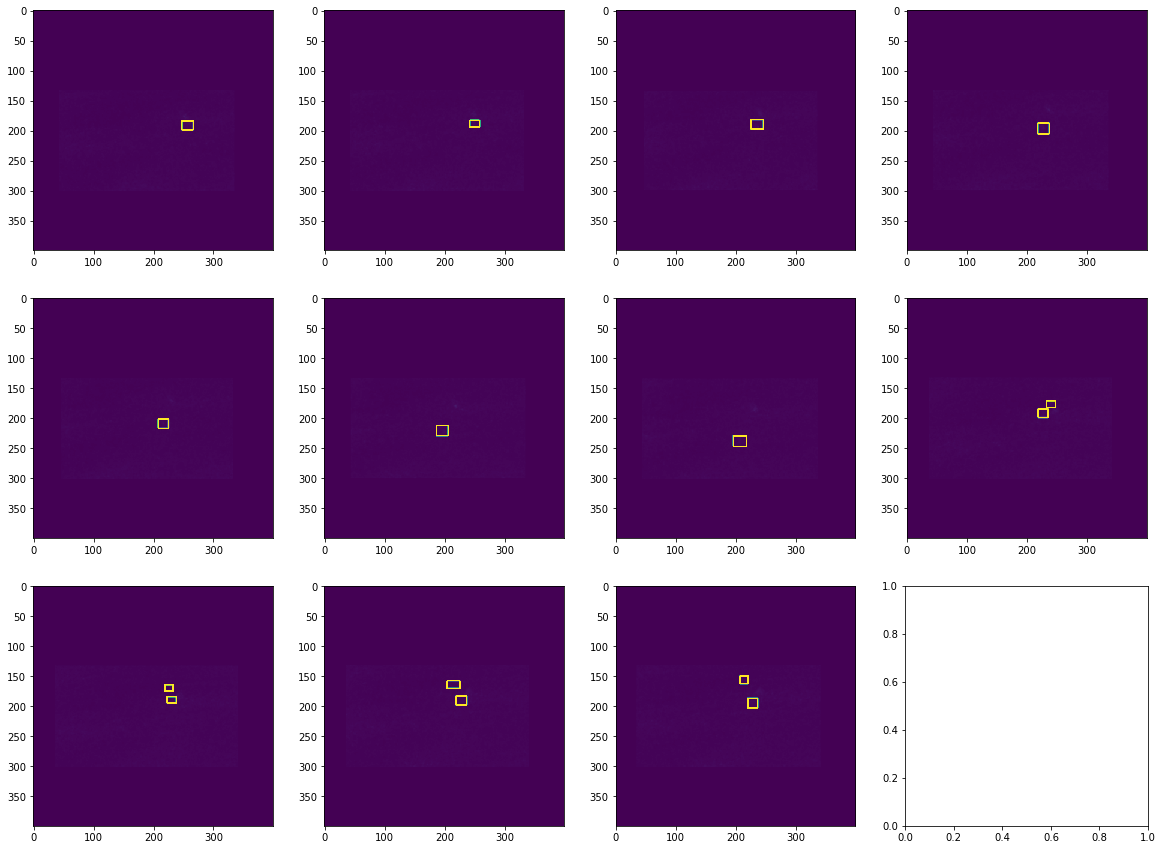

In [104]:
results = copy.deepcopy(main_labels)
img_res = []

for folder, boxes in main_labels.items():
    temp_img = anomaly_masks[folder]['3'].copy()
    #temp_img = cv2.cvtColor(temp_img.astype('uint8'), cv2.COLOR_GRAY2BGR)
    print(boxes[0])
    temp_img = add_bounding_boxes(temp_img, boxes, rgb_color=(0,255,0))
    temp_img = add_bounding_boxes(temp_img, labels[folder], rgb_color=(255,0,0))
    results[folder] = temp_img
    img_res.append(temp_img)

display_images(np.array(img_res), figsize=(3,4), resize_dim=(400,400))

In [85]:
result = ut.compute_AP(main_labels,labels)
print(result)

0.0


## Carson trying to replicate

In [64]:
#gets the difference between every image and every other image in the time step
#returns a list

def get_all_diffs(img_list):
    all_diffs = []

    for i in range(len(img_list)):
        for j in range(len(img_list)):
            temp = cv2.absdiff(img_list[i],img_list[j])
            all_diffs.append(temp)
    
    return all_diffs

In [ ]:
diffs = copy.deepcopy(anomaly_masks)

for folder, time_step_dict in anomaly_masks.items():
    image_sequence = []
    for time_step, mask in time_step_dict.items():
        image_sequence.append(anomaly_masks[folder][time_step])
    diffs[folder] = get_all_diffs(image_sequence)
    
#Check the differences
#should be 7x7=49 images, the differences of all images in 'valid-1-0'
display_images(diffs['valid-1-0'],figsize=(7,7), resize_dim=(400,400))

In [ ]:
diffs = copy.deepcopy(anomaly_masks)

all_images = []

for folder, time_step_dict in anomaly_masks.items():
    for time_step, mask in time_step_dict.items():
        all_images.append(anomaly_masks[folder][time_step])

overall_background = get_background_median(all_images)
print(overall_background.shape)
print(anomaly_masks['valid-1-0']['3'].shape)

for folder, time_step_dict in anomaly_masks.items():
    for time_step, mask in time_step_dict.items():
        diffs[folder][time_step] = cv2.absdiff(diffs[folder][time_step].astype('uint8'),overall_background.astype('uint8'))

#Check the differences
#should be 7x7=49 images, the differences of all images in 'valid-1-0'
"""
display_images([overall_background],figsize=(1,1),resize_dim=(400,400))
display_images([anomaly_masks['valid-1-0']['3']],figsize=(1,1),resize_dim=(400,400))
display_images([diffs['valid-1-0']['3']],figsize=(1,1),resize_dim=(400,400))
"""

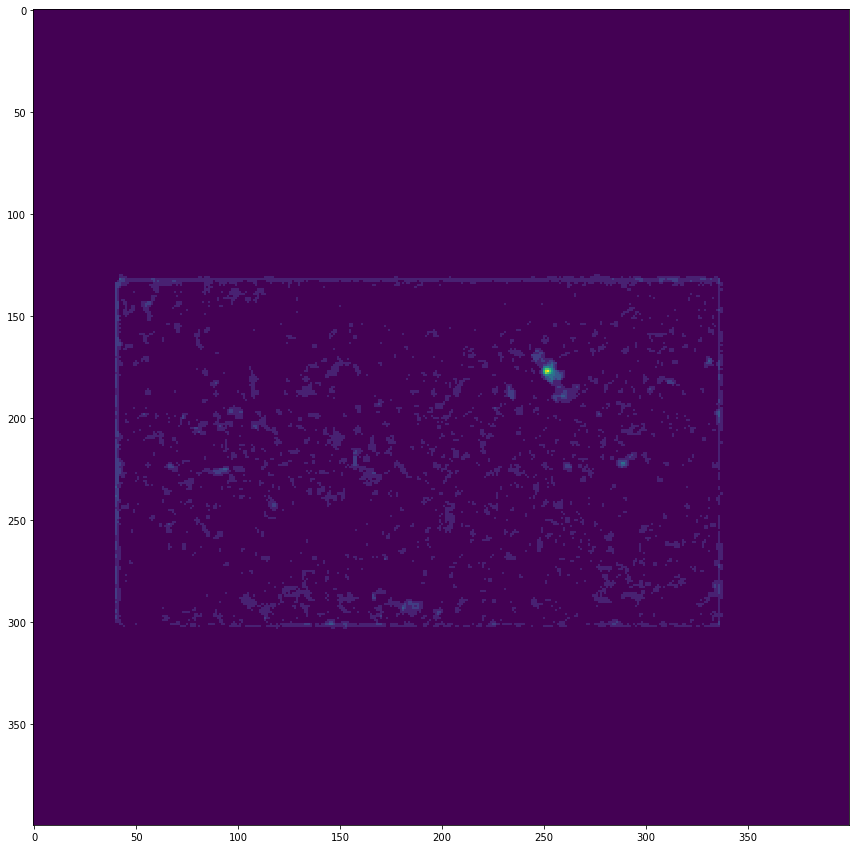

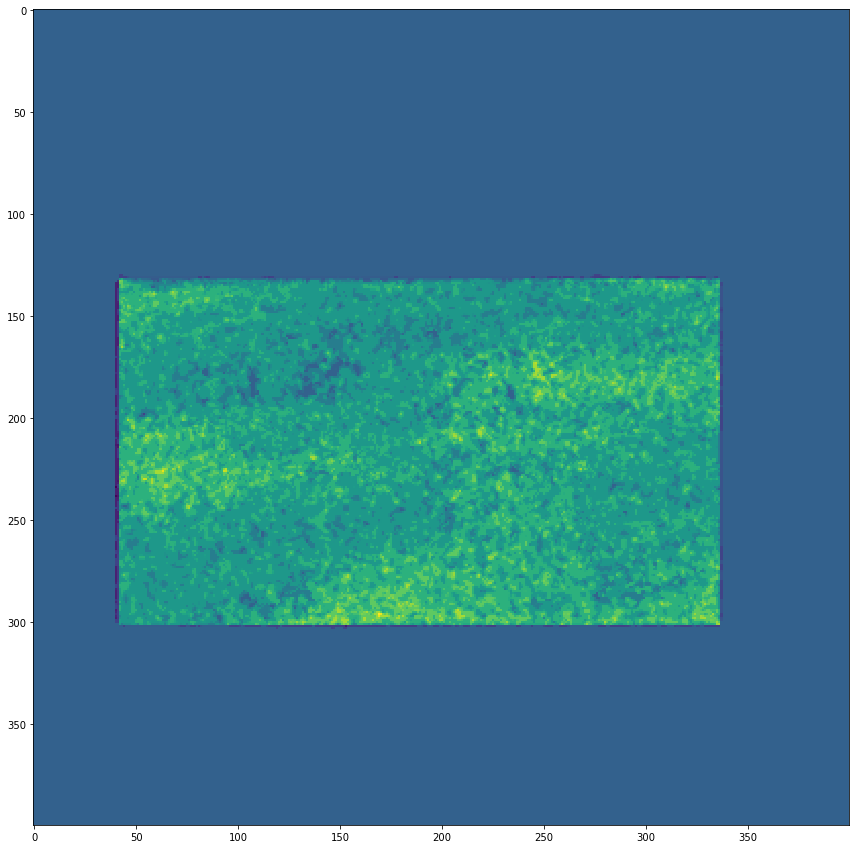

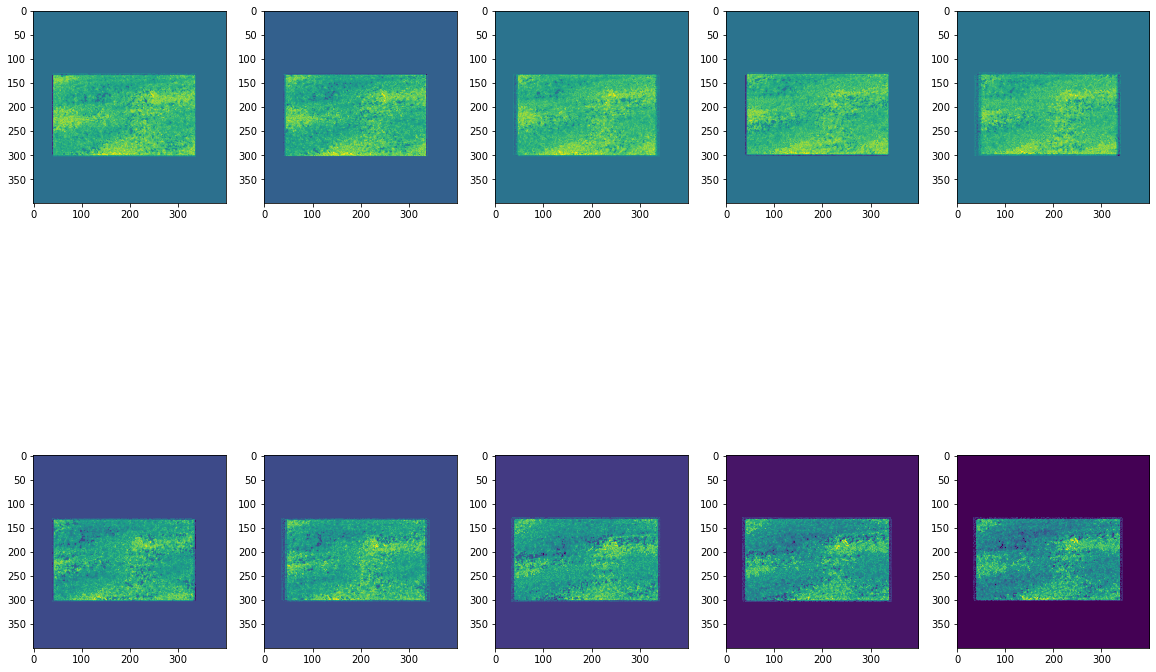

In [145]:
local_diffs = copy.deepcopy(anomaly_masks)
local_backs = copy.deepcopy(anomaly_masks)

for folder, time_step_dict in diffs.items():
    images = []
    for time_step, mask in time_step_dict.items():
        images.append(mask)
    local_backs[folder] = get_background_mean(images)

for folder, time_step_dict in local_diffs.items():
    for time_step, mask in time_step_dict.items():
        local_diffs[folder][time_step] = mask - local_backs[folder]

images = []
for folder, time_step_dict in local_diffs.items():
    summ = np.zeros(local_diffs[folder]['0'].shape)
    for time_step, mask in time_step_dict.items():
        summ = summ+mask
    images.append(summ)

display_images([local_backs['valid-1-0']],figsize=(1,1),resize_dim=(400,400))
display_images([local_diffs['valid-1-0']['3']],figsize=(1,1),resize_dim=(400,400))
display_images(images,figsize=(2,5),resize_dim=(400,400))

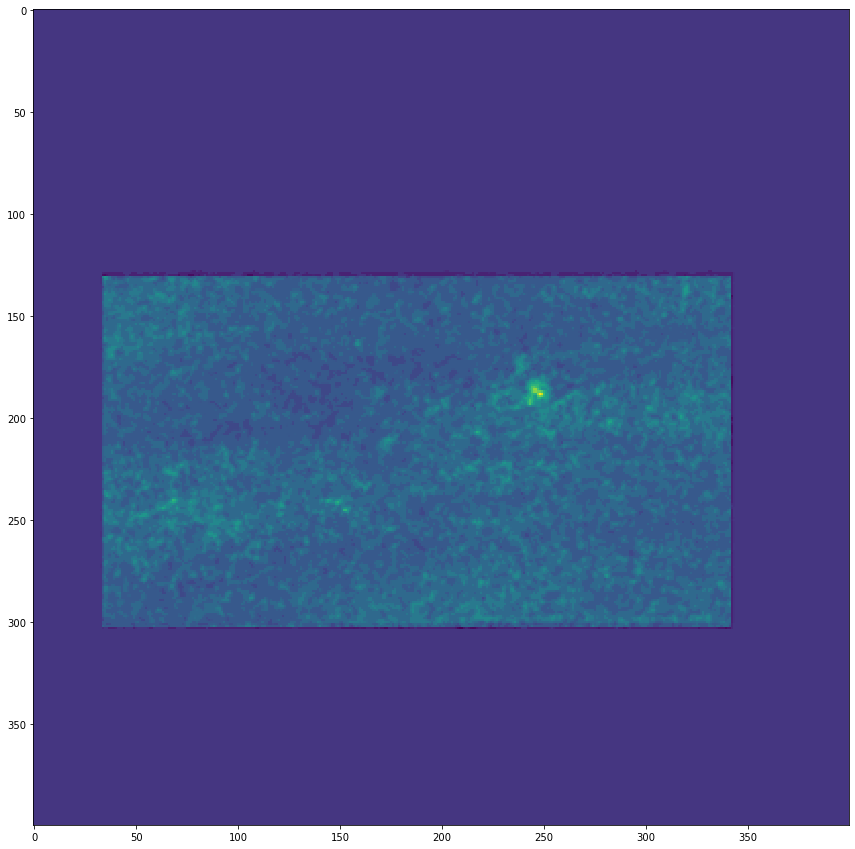

In [72]:
sub_back = copy.deepcopy(anomaly_masks)

for folder, time_step_dict in anomaly_masks.items():
    temp = get_background_mean(diffs[folder])
    for time_step, mask in time_step_dict.items():
        sub_back[folder][time_step] = mask - temp

#Check the differences
#should be 1 image, the mean of all the difference images from above
display_images([sub_back['valid-2-0']['3']],figsize=(1,1), resize_dim=(400,400))